In [2]:
import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.math as afwMath
import lsst.pex.config as pexConfig
import lsst.pipe.base as pipeBase
from lsst.cp.pipe.utils import (arrangeFlatsByExpTime, arrangeFlatsByExpId,
                                sigmaClipCorrection, CovFastFourierTransform)

import lsst.pipe.base.connectionTypes as cT

from lsst.ip.isr import PhotonTransferCurveDataset
from lsst.ip.isr import IsrTask

# Loading collection

In [3]:
genCollection = "u/lgiraldo/bps_ALLCCD_20220701"
butler = dB.Butler("/repo/main/", collections=genCollection)

# Functions

## With Mask
From https://github.com/lsst/cp_pipe/blob/main/python/lsst/cp/pipe/ptc/cpExtractPtcTask.py

In [4]:
##Config
binSize = 1
maskNameList=['SUSPECT', 'BAD', 'NO_DATA', 'SAT']
nSigmaClipPtc = 5.5
nIterSigmaClipPtc = 3

In [5]:
def getImageAreasMasksStats(exposure1, exposure2, region=None):
    """Get image areas in a region as well as masks and statistic objects.
    Parameters
    ----------
    exposure1 : `lsst.afw.image.exposure.ExposureF`
        First exposure of flat field pair.
    exposure2 : `lsst.afw.image.exposure.ExposureF`
        Second exposure of flat field pair.
    region : `lsst.geom.Box2I`, optional
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    Returns
    -------
    im1Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 1.
    im2Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 2.
    imStatsCtrl : `lsst.afw.math.StatisticsControl`
        Statistics control object.
    mu1: `float`
        Clipped mean of im1Area (ADU).
    mu2: `float`
        Clipped mean of im2Area (ADU).
    """
    if region is not None:
        im1Area = exposure1.maskedImage[region]
        im2Area = exposure2.maskedImage[region]
    else:
        im1Area = exposure1.maskedImage
        im2Area = exposure2.maskedImage

    if binSize > 1:
        im1Area = afwMath.binImage(im1Area, binSize)
        im2Area = afwMath.binImage(im2Area, binSize)

    # Get mask planes and construct statistics control object from one
    # of the exposures
    imMaskVal = exposure1.getMask().getPlaneBitMask(maskNameList)
    imStatsCtrl = afwMath.StatisticsControl(nSigmaClipPtc,
                                            nIterSigmaClipPtc,
                                            imMaskVal)
    imStatsCtrl.setNanSafe(True)
    imStatsCtrl.setAndMask(imMaskVal)

    mu1 = afwMath.makeStatistics(im1Area, afwMath.MEANCLIP, imStatsCtrl).getValue()
    mu2 = afwMath.makeStatistics(im2Area, afwMath.MEANCLIP, imStatsCtrl).getValue()

    return (im1Area, im2Area, imStatsCtrl, mu1, mu2)

def getGainFromFlatPair(im1Area, im2Area, imStatsCtrl, mu1, mu2,
                            correctionType='NONE', readNoise=None):
    """Estimate the gain from a single pair of flats.
    The basic premise is 1/g = <(I1 - I2)^2/(I1 + I2)> = 1/const,
    where I1 and I2 correspond to flats 1 and 2, respectively.
    Corrections for the variable QE and the read-noise are then
    made following the derivation in Robert Lupton's forthcoming
    book, which gets
    1/g = <(I1 - I2)^2/(I1 + I2)> - 1/mu(sigma^2 - 1/2g^2).
    This is a quadratic equation, whose solutions are given by:
    g = mu +/- sqrt(2*sigma^2 - 2*const*mu + mu^2)/(2*const*mu*2
        - 2*sigma^2)
    where 'mu' is the average signal level and 'sigma' is the
    amplifier's readnoise. The positive solution will be used.
    The way the correction is applied depends on the value
    supplied for correctionType.
    correctionType is one of ['NONE', 'SIMPLE' or 'FULL']
        'NONE' : uses the 1/g = <(I1 - I2)^2/(I1 + I2)> formula.
        'SIMPLE' : uses the gain from the 'NONE' method for the
                   1/2g^2 term.
        'FULL'   : solves the full equation for g, discarding the
                   non-physical solution to the resulting quadratic.
    Parameters
    ----------
    im1Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 1.
    im2Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 2.
    imStatsCtrl : `lsst.afw.math.StatisticsControl`
        Statistics control object.
    mu1: `float`
        Clipped mean of im1Area (ADU).
    mu2: `float`
        Clipped mean of im2Area (ADU).
    correctionType : `str`, optional
        The correction applied, one of ['NONE', 'SIMPLE', 'FULL']
    readNoise : `float`, optional
        Amplifier readout noise (ADU).
    Returns
    -------
    gain : `float`
        Gain, in e/ADU.
    Raises
    ------
        RuntimeError: if `correctionType` is not one of 'NONE',
            'SIMPLE', or 'FULL'.
    """
    if correctionType not in ['NONE', 'SIMPLE', 'FULL']:
        raise RuntimeError("Unknown correction type: %s" % correctionType)

    if correctionType != 'NONE' and readNoise is None:
        print("'correctionType' in 'getGainFromFlatPair' is %s, "
                         "but 'readNoise' is 'None'. Setting 'correctionType' "
                         "to 'NONE', so a gain value will be estimated without "
                         "corrections." % correctionType)
        correctionType = 'NONE'

    mu = 0.5*(mu1 + mu2)

    # ratioIm = (I1 - I2)^2 / (I1 + I2)
    temp = im2Area.clone()
    ratioIm = im1Area.clone()
    ratioIm -= temp
    ratioIm *= ratioIm
    

    # Sum of pairs
    sumIm = im1Area.clone()
    sumIm += temp
    ##################
    #mean_ratioIm = afwMath.makeStatistics(ratioIm, afwMath.MEANCLIP, imStatsCtrl).getValue()
    #mean_sumIm = afwMath.makeStatistics(sumIm, afwMath.MEANCLIP, imStatsCtrl).getValue()
    #const = mean_ratioIm/mean_sumIm 
    ##################
    ratioIm /= sumIm

    const = afwMath.makeStatistics(ratioIm, afwMath.MEANCLIP, imStatsCtrl).getValue()
    gain = 1. / const

    if correctionType == 'SIMPLE':
        gain = 1/(const - (1/mu)*(readNoise**2 - (1/2*gain**2)))
    elif correctionType == 'FULL':
        root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
        denom = (2*const*mu - 2*readNoise**2)
        positiveSolution = (root + mu)/denom
        gain = positiveSolution

    return gain

def getReadNoiseFromMetadata(taskMetadata, ampName):
    """Gets readout noise for an amp from ISR metadata.
    Parameters
    ----------
    taskMetadata : `list` [`lsst.pipe.base.TaskMetadata`]
                List of exposures metadata from ISR.
    ampName : `str`
        Amplifier name.
    Returns
    -------
    readNoise : `float`
        Median of the overscan readnoise in the
        post-ISR metadata of the input exposures (ADU).
        Returns 'None' if the median could not be calculated.
    """
    # Empirical readout noise [ADU] measured from an
    # overscan-subtracted overscan during ISR.
    expectedKey = f"RESIDUAL STDEV {ampName}"

    readNoises = []
    for meta in taskMetadata:
        for expMetadata in meta:
            if 'isr' in expMetadata:
                overscanNoise = meta['isr'][expectedKey]
            else:
                continue
            readNoises.append(overscanNoise)

    if len(readNoises):
        readNoise = np.median(np.array(readNoises))
    else:
        print("Median readout noise from ISR metadata for amp %s "
                         "could not be calculated." % ampName)
        readNoise = None
    
    return readNoise

## Without mask
From https://github.com/lsst/atmospec/blob/c867367d1bbf2d63a0076951aa44e4d0833417ae/python/lsst/atmospec/utils.py#L156

In [80]:
def getGainFromFlatPair_noMask(exposure1, exposure2, correctionType='NONE',
                            readNoise=None, region=None):
    """Estimate the gain from a single pair of flats.
    The basic premise is 1/g = <(I1 - I2)^2/(I1 + I2)>,
    where I1 and I2 correspond to flats 1 and 2, respectively.
    Corrections for the variable QE and the read-noise are then made
    following the derivation in Robert Lupton's forthcoming book,
    which gets
    1/g = <(I1 - I2)^2/(I1 + I2)> - 1/mu(sigma^2 - 1/2g^2)
    See below for the full solution.
    https://www.wolframalpha.com/input/?i=solve+1%2Fy+%3D+c+-+(1%2Fm)*(s^2+-+1%2F(2y^2))+for+y
    where mu is the average signal level, and sigma is the
    amplifier's readnoise. The way the correction is applied depends on
    the value supplied for correctionType.
    correctionType is one of ['NONE', 'SIMPLE' or 'FULL']
        'NONE' : uses the 1/g = <(I1 - I2)^2/(I1 + I2)> formula
        'SIMPLE' : uses the gain from the 'NONE' method for the 1/2g^2 term
        'FULL'   : solves the full equation for g, discarding the
                   non-physical solution to the resulting quadratic.
    Parameters
    ----------
    exposure1 : `lsst.afw.image.exposure.ExposureF`
        First exposure of flat field pair.
    exposure2 : `lsst.afw.image.exposure.ExposureF`
        Second exposure of flat field pair.
    correctionType : `str`, optional
        The correction applied, one of ['NONE', 'SIMPLE', 'FULL']
    readnoise : `float`, optional
        Amplifier readout noise.
    region : `lsst.geom.Box2I`, optional
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    Returns
    -------
    gain : `float`
        Gain, in e/ADU.
    Raises
    ------
        RuntimeError: if `correctionType` is not one of 'NONE',
            'SIMPLE', or 'FULL'.
        RuntimeError: if a readout noise value is not provided
            when `correctionType` is different from 'NONE'.
    """
    if correctionType not in ['NONE', 'SIMPLE', 'FULL']:
        raise RuntimeError("Unknown correction type %s" % correctionType)

    if correctionType != 'NONE' and readNoise is None:
        raise RuntimeError("Must supply a readout noise value if "
                           "performing gain correction.")

    if region is not None:
        im1Area = exposure1.getImage()[region].getArray()
        im2Area = exposure2.getImage()[region].getArray()
    else:
        im1Area = exposure1.getImage().getArray()
        im2Area = exposure2.getImage().getArray()

    #const = np.mean((im1Area - im2Area)**2)/ np.mean((im1Area + im2Area))
    const = np.mean((im1Area - im2Area)**2 / (im1Area + im2Area))
    gain = 1. / const
    #print(gain)
    
    mu = 0.5*(np.mean(im1Area) + np.mean(im2Area))

    if correctionType == 'SIMPLE':
        gain = 1/(const - (1/mu)*(readNoise**2 - (1/2*gain**2)))
    elif correctionType == 'FULL':
        root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
        denom = (2*const*mu - 2*readNoise**2)

        positiveSolution = (root + mu)/denom
        negativeSolution = (mu - root)/denom  # noqa: F841 unused, but the other solution

        gain = positiveSolution

    return gain

## Plot images

In [7]:
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from lsst.afw import cameraGeom
import pylab as plt

def plotMask(mask, title=''):  
        """Plot exposures
        
        Parameters
        ----------
        mask: lsst.afw.image.maskedImage.MaskedImageF
        title: `str`
            The type of image, e.g., 'bias', 'dark', 'flat'.
        """

        disp = afwDisplay.Display(backend="matplotlib", dpi=200)

        mpDict = mask.mask.getMaskPlaneDict()
        mask_plane="BAD", #"NO_DATA"
        for plane in mpDict.keys():
            if plane in [mask_plane]:
                continue
            disp.setMaskPlaneColor(plane, afwDisplay.IGNORE)

        disp.scale('asinh', 'zscale')
        disp.setMaskTransparency(80)
        disp.setMaskPlaneColor(mask_plane, afwDisplay.RED)

        disp.setImageColormap('gray')
        title = ""
        disp.mtv(mask, title=title)
        #disp.savefig('Flat.png')
        return
    

def plotImages(exp, title=''):  
        """Plot exposures
        
        Parameters
        ----------
        exp : `lsst.afw.image.exposure.Exposure`
            The exposure in which the defects were found.
        title: `str`
            The type of image, e.g., 'bias', 'dark', 'flat'.
        """
        expCopy = exp.clone()  # we mess with the copy later, so make a clone
        print (f'imprimiedo exp: {exp}')
        del exp  # del for safety - no longer needed as we have a copy so remove from scope to save mistakes
        maskedIm = expCopy.maskedImage
       
        detector = expCopy.getDetector()

        disp = afwDisplay.Display(backend="matplotlib", dpi=200)

        mpDict = maskedIm.mask.getMaskPlaneDict()
        mask_plane="BAD", #"NO_DATA"
        for plane in mpDict.keys():
            if plane in [mask_plane]:
                continue
            disp.setMaskPlaneColor(plane, afwDisplay.IGNORE)

        disp.scale('asinh', 'zscale')
        disp.setMaskTransparency(80)
        disp.setMaskPlaneColor(mask_plane, afwDisplay.RED)

        disp.setImageColormap('gray')
        title = ""
        disp.mtv(maskedIm, title=title)
        #disp.savefig('Flat.png')
        return

In [8]:
exposure_pairs = np.load('./Data_files/exposure_pairs.txt.npy')

In [9]:
exp_index = np.where(exposure_pairs == [3021120700503, 3021120700504])[0][0]
exp_index

230

In [10]:
#These exposures have a mean of around  5000 ADU
CCD = 55

exp1 = butler.get('cpPtcProc', detector=CCD, exposure=exposure_pairs[exp_index, 0], instrument='LSSTCam')
exp2 = butler.get('cpPtcProc', detector=CCD, exposure=exposure_pairs[exp_index, 1], instrument='LSSTCam')

# Camera, detector and amplifier as objects

In [11]:
camera = butler.get("camera", instrument="LSSTCam")  ## Camera object
for det in camera:
    if det.getId() == CCD:
        detector = det  ##Detector object
        
amp_object = {}
ampNames = []  ##Amplifier names

for amp in detector:
    amp_object[amp.getName()] = amp.getBBox()  ## Amplifier location
    ampNames += [amp.getName()]
    
amp_object

{'C10': Box2I(corner=Point2I(0, 2002), dimensions=Extent2I(512, 2002)),
 'C11': Box2I(corner=Point2I(512, 2002), dimensions=Extent2I(512, 2002)),
 'C12': Box2I(corner=Point2I(1024, 2002), dimensions=Extent2I(512, 2002)),
 'C13': Box2I(corner=Point2I(1536, 2002), dimensions=Extent2I(512, 2002)),
 'C14': Box2I(corner=Point2I(2048, 2002), dimensions=Extent2I(512, 2002)),
 'C15': Box2I(corner=Point2I(2560, 2002), dimensions=Extent2I(512, 2002)),
 'C16': Box2I(corner=Point2I(3072, 2002), dimensions=Extent2I(512, 2002)),
 'C17': Box2I(corner=Point2I(3584, 2002), dimensions=Extent2I(512, 2002)),
 'C07': Box2I(corner=Point2I(3584, 0), dimensions=Extent2I(512, 2002)),
 'C06': Box2I(corner=Point2I(3072, 0), dimensions=Extent2I(512, 2002)),
 'C05': Box2I(corner=Point2I(2560, 0), dimensions=Extent2I(512, 2002)),
 'C04': Box2I(corner=Point2I(2048, 0), dimensions=Extent2I(512, 2002)),
 'C03': Box2I(corner=Point2I(1536, 0), dimensions=Extent2I(512, 2002)),
 'C02': Box2I(corner=Point2I(1024, 0), dimen

# Read-out noise

In [12]:
readNoiseDict = {ampName: [] for ampName in ampNames}

metadata1 = butler.get('isr_metadata', detector=CCD, instrument='LSSTCam', exposure=exposure_pairs[exp_index, 0])
metadata2 = butler.get('isr_metadata', detector=CCD, instrument='LSSTCam', exposure=exposure_pairs[exp_index, 1])

##Saving metadata for pair of flats
metadata = [metadata1, metadata2]
metadata

for ampName in ampNames:
    # Overscan readnoise from post-ISR exposure metadata.
    # It will be used to estimate the gain from a pair of flats.
    readNoiseDict[ampName].append(getReadNoiseFromMetadata(metadata, ampName))

In [13]:
readNoiseDict

{'C10': [3.603849701748253],
 'C11': [3.578682818253572],
 'C12': [3.589762850275914],
 'C13': [3.6181512974790953],
 'C14': [3.7682542438163846],
 'C15': [3.5470712478194253],
 'C16': [3.5327636833256095],
 'C17': [3.6796256741292526],
 'C07': [3.7125723471204037],
 'C06': [3.727220970059814],
 'C05': [3.547040778016429],
 'C04': [3.495840711411364],
 'C03': [3.4996398778511297],
 'C02': [3.4818950513058287],
 'C01': [3.503855619720707],
 'C00': [3.4635965249370786]}

# Gain analysis

In [14]:
def mask_nomask_func(amp, corr_type, region_obj):
    """
    This function calculates the gain using a pair of flats with and without mask in the image.
    
    Parameters
    ----------
    amp: str with amplifier name, e.g. 'C00'
    corr_type: str, one of ['NONE', 'SIMPLE', 'FULL']
    region_obj: `lsst.geom.Box2I`
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    
    Returns
    -------
    gain_nomask: float, gain calculated without mask
    gain_mask: float, gain calculated with mask
    rel_nomask: float, relative percentage error between gain from 'gain_nomask' and PTC gain
    rel_mask: float, relative percentage error between gain from 'gain_mask' and PTC gain
    """
    
    mask1, mask2, stat_c, mu1, mu2 = getImageAreasMasksStats(exp1, exp2, region=region_obj)
    
    if corr_type == 'NONE':
        gain_nomask = getGainFromFlatPair_noMask(exp1, exp2, correctionType='NONE',
                                readNoise=None, region=region_obj)
        gain_mask = getGainFromFlatPair(mask1, mask2, stat_c, mu1, mu2, correctionType='NONE', 
                                               readNoise=None)
    else:
        gain_nomask = getGainFromFlatPair_noMask(exp1, exp2, correctionType=corr_type,
                            readNoise=readNoiseDict[amp][0], region=region_obj)
        gain_mask = getGainFromFlatPair(mask1, mask2, stat_c, mu1, mu2, correctionType=corr_type, 
                                           readNoise=readNoiseDict[amp][0])
    rel_nomask = abs(gain_nomask- ptc_gain[amp])/ptc_gain[amp]*100
    rel_mask = abs(gain_mask - ptc_gain[amp])/ptc_gain[amp]*100
        
    return gain_nomask, gain_mask, rel_nomask, rel_mask

In [15]:
ccd_data= butler.get("ptc", instrument="LSSTCam", detector=CCD)
ptc_gain = ccd_data.gain

In [16]:
none = [] #gain_nomask, gain_mask, rel_nomask, rel_mask
simple = []
full = []
for amp in ampNames:
    none += [mask_nomask_func(amp, 'NONE', amp_object[amp])]
    simple += [mask_nomask_func(amp, 'SIMPLE', amp_object[amp])]
    full += [mask_nomask_func(amp, 'FULL', amp_object[amp])]

In [17]:
none = np.array(none)
simple = np.array(simple)
full = np.array(full)

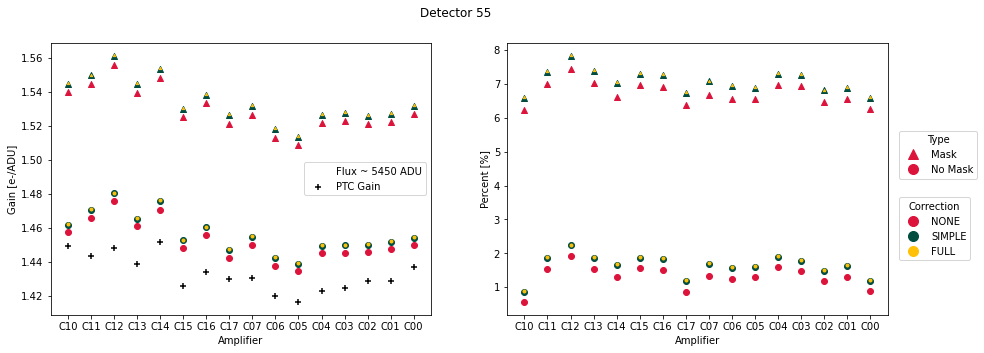

In [18]:
fig,axes = plt.subplots(1,2, figsize= (15,5))
fig.suptitle('Detector 55')
axes[0].scatter(ampNames, none[:,0], c= 'crimson')
axes[0].scatter(ampNames, simple[:,0], c= '#004D40')
axes[0].scatter(ampNames, full[:,0], c= '#FFC107', marker = '.')

axes[0].scatter(ampNames, none[:,1], c= 'crimson', marker = '^')
axes[0].scatter(ampNames, simple[:,1], c= '#004D40',marker = '^')
axes[0].scatter(ampNames, full[:,1], c= '#FFC107', marker = '^', s = 5)

axes[0].plot([], [], '.', label='Flux ~ 5450 ADU', ms = 0.5, color='white');
axes[0].scatter(ptc_gain.keys(), ptc_gain.values(), c='black', marker= '+', label='PTC Gain');

axes[1].scatter(ampNames, none[:,2], c= 'crimson')
axes[1].scatter(ampNames, simple[:,2], c= '#004D40')
axes[1].scatter(ampNames, full[:,2], c= '#FFC107', marker = '.')

axes[1].scatter(ampNames, none[:,3], c= 'crimson', marker = '^')
axes[1].scatter(ampNames, simple[:,3], c= '#004D40', marker = '^')
axes[1].scatter(ampNames, full[:,3], c= '#FFC107', marker = '^', s = 5)

for i in range(2):
    axes[i].set_xlabel('Amplifier')
axes[0].set_ylabel('Gain [e-/ADU]')
axes[1].set_ylabel('Percent [%]')

axes[0].legend(loc='center right')

t = plt.plot([],[], color="crimson", marker="^", ms=10, ls="")[0]
c = plt.plot([],[], color="crimson", marker="o", ms=10, ls="")[0]
lg1 = plt.legend(handles=[t,c], labels=['Mask','No Mask'],loc=(1.03,0.5), title="Type")
axes[1].add_artist(lg1)
n = plt.plot([],[], color="crimson", marker="o", ms=10, ls="")[0]
s = plt.plot([],[], color='#004D40', marker="o", ms=10, ls="")[0]
f = plt.plot([],[], color='#FFC107', marker="o", ms=10, ls="")[0]
plt.legend(handles=[n,s,f], labels=['NONE','SIMPLE', 'FULL'],loc=(1.03,0.2), title="Correction");

# Region and full image

In [19]:
mask1, mask2, stat_c, mu1, mu2 = getImageAreasMasksStats(exp1, exp2, region=amp_object['C00'])

plotMask(mask1.mask)

mask1, mask2, stat_c, mu1, mu2 = getImageAreasMasksStats(exp1, exp2)
print(mu1, mu2)
im1Area = exp1.getImage().getArray()
im2Area = exp2.getImage().getArray()

print(np.mean(im1Area), np.mean(im2Area))
np.mean([mu1, mu2, np.mean(im1Area), np.mean(im2Area)])

AttributeError: 'lsst.afw.image.image._imageLib.MaskX' object has no attribute 'mask'

<Figure size 1200x800 with 0 Axes>

In [ ]:
plotImages(exp1)

In [ ]:
plt.imshow(mask1.mask.array, vmin = 0, vmax=1)

In [ ]:
max(mask1.mask.array.ravel())

In [ ]:
plt.hist(mask1.mask.array.ravel(),  fc='k', ec='k');
plt.yscale('log')

In [ ]:
plt.hist(mask1.image.array.ravel(), bins = 200, fc='k', ec='k');

In [ ]:
def getImageAreasMasksStats(exposure1, exposure2, region=None):
    """Get image areas in a region as well as masks and statistic objects.
    Parameters
    ----------
    exposure1 : `lsst.afw.image.exposure.ExposureF`
        First exposure of flat field pair.
    exposure2 : `lsst.afw.image.exposure.ExposureF`
        Second exposure of flat field pair.
    region : `lsst.geom.Box2I`, optional
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    Returns
    -------
    im1Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 1.
    im2Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 2.
    imStatsCtrl : `lsst.afw.math.StatisticsControl`
        Statistics control object.
    mu1: `float`
        Clipped mean of im1Area (ADU).
    mu2: `float`
        Clipped mean of im2Area (ADU).
    """
    if region is not None:
        im1Area = exposure1.maskedImage[region]
        im2Area = exposure2.maskedImage[region]
    else:
        im1Area = exposure1.maskedImage
        im2Area = exposure2.maskedImage

    if binSize > 1:
        im1Area = afwMath.binImage(im1Area, binSize)
        im2Area = afwMath.binImage(im2Area, binSize)

    # Get mask planes and construct statistics control object from one
    # of the exposures
    imMaskVal = exposure1.getMask().getPlaneBitMask(maskNameList)
    imStatsCtrl = afwMath.StatisticsControl(nSigmaClipPtc,
                                            nIterSigmaClipPtc,
                                            imMaskVal)
    imStatsCtrl.setNanSafe(True)
    imStatsCtrl.setAndMask(imMaskVal)

    mu1 = afwMath.makeStatistics(im1Area, afwMath.MEANCLIP, imStatsCtrl).getValue()
    mu2 = afwMath.makeStatistics(im2Area, afwMath.MEANCLIP, imStatsCtrl).getValue()

    return (im1Area, im2Area, imStatsCtrl, mu1, mu2)

In [ ]:
mask1, mask2, stat_c, mu1, mu2 = getImageAreasMasksStats(exp1, exp2, region=amp_object['C02'])
region = amp_object['C02']
im1Area = exp1.maskedImage[region]
im2Area = exp2.maskedImage[region]
umask = np.logical_or(im1Area.mask, im2Area.mask)


#np.shape(im2Area.image.array)
umask

In [ ]:
new_mask = np.full_like(umask, 512)
im1Area.mask.array[:] = new_mask
#im1Area

In [ ]:
im1Area

In [ ]:
imMaskVal = exp1.getMask().getPlaneBitMask(maskNameList)
imMaskVal

In [ ]:
umask.printMaskPlanes()

In [ ]:
exp1.mask.printMaskPlanes()

In [ ]:
np.unique(im2Area.mask.array)

In [ ]:
im1Area.setMask?

In [ ]:
old = im1Area
new = im1Area.setMask(umask)

plt.hist(old.mask.array,  fc='k', ec='k');
plt.yscale('log')


In [ ]:
print(new)

In [ ]:
mask1, mask2, stat_c, mu1, mu2 = getImageAreasMasksStats(exp1, exp2, region=amp_object['C02'])
region = amp_object['C02']
im1Area = exp1.maskedImage[region]
im2Area = exp2.maskedImage[region]
umask = np.logical_or(im1Area.mask, im2Area.mask)

exp1.maskedImage[region]

In [ ]:
umask = umask.array.ravel()
plt.hist(umask,  fc='k', ec='k', bins=2);
plt.yscale('log')
min(umask.ravel()), max(umask.ravel()), max(mask1.mask.array.ravel()), max(mask2.mask.array.ravel())


In [ ]:
def mask_func(amp, corr_type, region_obj, mask):
    """
    This function calculates the gain using a pair of flats with and without mask in the image.
    
    Parameters
    ----------
    amp: str with amplifier name, e.g. 'C00'
    corr_type: str, one of ['NONE', 'SIMPLE', 'FULL']
    region_obj: `lsst.geom.Box2I`
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    
    Returns
    -------
    gain_nomask: float, gain calculated without mask
    gain_mask: float, gain calculated with mask
    rel_nomask: float, relative percentage error between gain from 'gain_nomask' and PTC gain
    rel_mask: float, relative percentage error between gain from 'gain_mask' and PTC gain
    """
    
    mask1, mask2, stat_c, mu1, mu2 = getImageAreasMasksStats(exp1, exp2, region=region_obj)
    umask = np.bitwise_or(mask1.mask.array, mask2.mask.array)
    
    if corr_type == 'NONE':
        gain_nomask = getGainFromFlatPair_noMask(exp1, exp2, correctionType='NONE',
                                readNoise=None, region=region_obj)
        gain_mask = getGainFromFlatPair(mask1, mask2, stat_c, mu1, mu2, correctionType='NONE', 
                                               readNoise=None)
    else:
        gain_nomask = getGainFromFlatPair_noMask(exp1, exp2, correctionType=corr_type,
                            readNoise=readNoiseDict[amp][0], region=region_obj)
        gain_mask = getGainFromFlatPair(mask1, mask2, stat_c, mu1, mu2, correctionType=corr_type, 
                                           readNoise=readNoiseDict[amp][0])
    rel_nomask = abs(gain_nomask- ptc_gain[amp])/ptc_gain[amp]*100
    rel_mask = abs(gain_mask - ptc_gain[amp])/ptc_gain[amp]*100
        
    return gain_nomask, gain_mask, rel_nomask, rel_mask

In [ ]:
exp1.getMask().getPlaneBitMask('SAT')

In [ ]:
maskNameList

In [ ]:
exp1 = butler.get('cpPtcProc', detector=CCD, exposure=exposure_pairs[exp_index, 0], instrument='LSSTCam')
exp2 = butler.get('cpPtcProc', detector=CCD, exposure=exposure_pairs[exp_index, 1], instrument='LSSTCam')
region = amp_object['C02']
im2Area = exp2.maskedImage[region]

In [ ]:
im2Area

# Adding one mask

In [22]:
def getImageAreasMasksStats(exposure1, region=None):
    """Get image areas in a region as well as masks and statistic objects.
    Parameters
    ----------
    exposure1 : `lsst.afw.image.exposure.ExposureF`
        First exposure of flat field pair.
    exposure2 : `lsst.afw.image.exposure.ExposureF`
        Second exposure of flat field pair.
    region : `lsst.geom.Box2I`, optional
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    Returns
    -------
    im1Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 1.
    im2Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 2.
    imStatsCtrl : `lsst.afw.math.StatisticsControl`
        Statistics control object.
    mu1: `float`
        Clipped mean of im1Area (ADU).
    mu2: `float`
        Clipped mean of im2Area (ADU).
    """
    if region is not None:
        im1Area = exposure1.maskedImage[region]
    else:
        im1Area = exposure1.maskedImage

    if binSize > 1:
        im1Area = afwMath.binImage(im1Area, binSize)

    # Get mask planes and construct statistics control object from one
    # of the exposures
    imMaskVal = exposure1.getMask().getPlaneBitMask(maskNameList)
    imStatsCtrl = afwMath.StatisticsControl(nSigmaClipPtc,
                                            nIterSigmaClipPtc,
                                            imMaskVal)
    imStatsCtrl.setNanSafe(True)
    imStatsCtrl.setAndMask(imMaskVal)

    mu1 = afwMath.makeStatistics(im1Area, afwMath.MEANCLIP, imStatsCtrl).getValue()

    return (im1Area, imStatsCtrl, mu1)

In [81]:
def getGainFromFlatPair_noMask1(im1Area, exposure2, mu1, correctionType='NONE',
                            readNoise=None, region=None):
    """Estimate the gain from a single pair of flats.
    The basic premise is 1/g = <(I1 - I2)^2/(I1 + I2)>,
    where I1 and I2 correspond to flats 1 and 2, respectively.
    Corrections for the variable QE and the read-noise are then made
    following the derivation in Robert Lupton's forthcoming book,
    which gets
    1/g = <(I1 - I2)^2/(I1 + I2)> - 1/mu(sigma^2 - 1/2g^2)
    See below for the full solution.
    https://www.wolframalpha.com/input/?i=solve+1%2Fy+%3D+c+-+(1%2Fm)*(s^2+-+1%2F(2y^2))+for+y
    where mu is the average signal level, and sigma is the
    amplifier's readnoise. The way the correction is applied depends on
    the value supplied for correctionType.
    correctionType is one of ['NONE', 'SIMPLE' or 'FULL']
        'NONE' : uses the 1/g = <(I1 - I2)^2/(I1 + I2)> formula
        'SIMPLE' : uses the gain from the 'NONE' method for the 1/2g^2 term
        'FULL'   : solves the full equation for g, discarding the
                   non-physical solution to the resulting quadratic.
    Parameters
    ----------
    exposure1 : `lsst.afw.image.exposure.ExposureF`
        First exposure of flat field pair.
    exposure2 : `lsst.afw.image.exposure.ExposureF`
        Second exposure of flat field pair.
    correctionType : `str`, optional
        The correction applied, one of ['NONE', 'SIMPLE', 'FULL']
    readnoise : `float`, optional
        Amplifier readout noise.
    region : `lsst.geom.Box2I`, optional
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    Returns
    -------
    gain : `float`
        Gain, in e/ADU.
    Raises
    ------
        RuntimeError: if `correctionType` is not one of 'NONE',
            'SIMPLE', or 'FULL'.
        RuntimeError: if a readout noise value is not provided
            when `correctionType` is different from 'NONE'.
    """
    if correctionType not in ['NONE', 'SIMPLE', 'FULL']:
        raise RuntimeError("Unknown correction type %s" % correctionType)

    if correctionType != 'NONE' and readNoise is None:
        raise RuntimeError("Must supply a readout noise value if "
                           "performing gain correction.")

    if region is not None:
        im2Area = exposure2.getImage()[region].getArray()
    else:
        im2Area = exposure2.getImage().getArray()
    
    ##Applying mask into image 1 
    im1Area = np.ma.masked_where(im1Area.mask.array, im1Area.image.array)
    const = np.mean((im1Area - im2Area)**2 / (im1Area + im2Area))
    gain = 1. / const

    mu = 0.5*(mu1 + np.mean(im2Area))

    if correctionType == 'SIMPLE':
        gain = 1/(const - (1/mu)*(readNoise**2 - (1/2*gain**2)))
    elif correctionType == 'FULL':
        root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
        denom = (2*const*mu - 2*readNoise**2)

        positiveSolution = (root + mu)/denom
        negativeSolution = (mu - root)/denom  # noqa: F841 unused, but the other solution

        gain = positiveSolution

    return gain

In [82]:
CCD = 55

exp1 = butler.get('cpPtcProc', detector=CCD, exposure=exposure_pairs[exp_index, 0], instrument='LSSTCam')
exp2 = butler.get('cpPtcProc', detector=CCD, exposure=exposure_pairs[exp_index, 1], instrument='LSSTCam')
amp = 'C00'
im1Area, imStatsCtrl, mu1 = getImageAreasMasksStats(exp1, region = amp_object[amp])

In [83]:
getGainFromFlatPair_noMask1(im1Area, exp2, mu1, correctionType='NONE',
                            readNoise=None, region=amp_object[amp])

1.4499532708173404

In [84]:
np.unique(im1Area.mask.array)

array([0, 1], dtype=int32)

In [85]:
def mask_nomask_func(amp, corr_type, region_obj):
    """
    This function calculates the gain using a pair of flats with and without mask in the image.
    
    Parameters
    ----------
    amp: str with amplifier name, e.g. 'C00'
    corr_type: str, one of ['NONE', 'SIMPLE', 'FULL']
    region_obj: `lsst.geom.Box2I`
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    
    Returns
    -------
    gain_nomask: float, gain calculated without mask
    gain_mask: float, gain calculated with mask
    rel_nomask: float, relative percentage error between gain from 'gain_nomask' and PTC gain
    rel_mask: float, relative percentage error between gain from 'gain_mask' and PTC gain
    """
    
    mask1, stat_c, mu1= getImageAreasMasksStats(exp1, region=region_obj)
    
    if corr_type == 'NONE':
        gain_nomask = getGainFromFlatPair_noMask(exp1, exp2, correctionType='NONE',
                                readNoise=None, region=region_obj)
        gain_mask = getGainFromFlatPair_noMask1(mask1, exp2, mu1, correctionType='NONE', 
                                               readNoise=None, region=region_obj)
    else:
        gain_nomask = getGainFromFlatPair_noMask(exp1, exp2, correctionType=corr_type,
                            readNoise=readNoiseDict[amp][0], region=region_obj)
        gain_mask = getGainFromFlatPair_noMask1(mask1, exp2, mu1, correctionType=corr_type, 
                                           readNoise=readNoiseDict[amp][0], region=region_obj)
    rel_nomask = abs(gain_nomask- ptc_gain[amp])/ptc_gain[amp]*100
    rel_mask = abs(gain_mask - ptc_gain[amp])/ptc_gain[amp]*100
        
    return gain_nomask, gain_mask, rel_nomask, rel_mask

In [86]:
none = [] #gain_nomask, gain_mask, rel_nomask, rel_mask
simple = []
full = []
for amp in ampNames:
    none += [mask_nomask_func(amp, 'NONE', amp_object[amp])]
    simple += [mask_nomask_func(amp, 'SIMPLE', amp_object[amp])]
    full += [mask_nomask_func(amp, 'FULL', amp_object[amp])]
    
none = np.array(none)
simple = np.array(simple)
full = np.array(full)

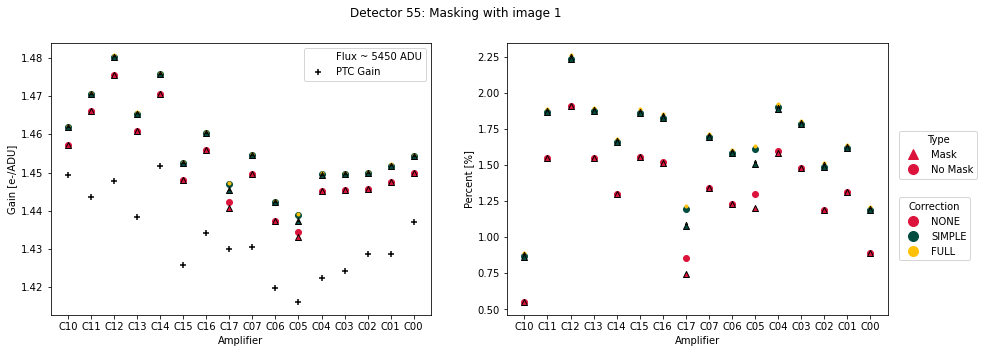

In [92]:
fig,axes = plt.subplots(1,2, figsize= (15,5))
fig.suptitle('Detector 55: Masking with image 1')
axes[0].scatter(ampNames, none[:,0], c= 'crimson')
axes[0].scatter(ampNames, simple[:,0], c= '#004D40')
axes[0].scatter(ampNames, full[:,0], c= '#FFC107', marker = '.')

axes[0].scatter(ampNames, none[:,1], c= 'crimson', marker = '^', edgecolor = 'black')
axes[0].scatter(ampNames, simple[:,1], c= '#004D40',marker = '^', edgecolor = 'black')
axes[0].scatter(ampNames, full[:,1], c= '#FFC107', marker = '^', s = 5, edgecolor = 'black')

axes[0].plot([], [], '.', label='Flux ~ 5450 ADU', ms = 0.5, color='white');
axes[0].scatter(ptc_gain.keys(), ptc_gain.values(), c='black', marker= '+', label='PTC Gain');

axes[1].scatter(ampNames, none[:,2], c= 'crimson')
axes[1].scatter(ampNames, simple[:,2], c= '#004D40')
axes[1].scatter(ampNames, full[:,2], c= '#FFC107', marker = '.')

axes[1].scatter(ampNames, none[:,3], c= 'crimson', marker = '^', edgecolor = 'black')
axes[1].scatter(ampNames, simple[:,3], c= '#004D40', marker = '^', edgecolor = 'black')
axes[1].scatter(ampNames, full[:,3], c= '#FFC107', marker = '^', s = 5, edgecolor = 'black')

for i in range(2):
    axes[i].set_xlabel('Amplifier')
axes[0].set_ylabel('Gain [e-/ADU]')
axes[1].set_ylabel('Percent [%]')

axes[0].legend(loc='best')

t = plt.plot([],[], color="crimson", marker="^", ms=10, ls="")[0]
c = plt.plot([],[], color="crimson", marker="o", ms=10, ls="")[0]
lg1 = plt.legend(handles=[t,c], labels=['Mask','No Mask'],loc=(1.03,0.5), title="Type")
axes[1].add_artist(lg1)
n = plt.plot([],[], color="crimson", marker="o", ms=10, ls="")[0]
s = plt.plot([],[], color='#004D40', marker="o", ms=10, ls="")[0]
f = plt.plot([],[], color='#FFC107', marker="o", ms=10, ls="")[0]
plt.legend(handles=[n,s,f], labels=['NONE','SIMPLE', 'FULL'],loc=(1.03,0.2), title="Correction");

# Two different masks

In [136]:
from astropy.stats import sigma_clip
def getGainFromFlatPair_noMask2(exposure1, exposure2, correctionType='NONE',
                            readNoise=None, region=None):
    """Estimate the gain from a single pair of flats.
    The basic premise is 1/g = <(I1 - I2)^2/(I1 + I2)>,
    where I1 and I2 correspond to flats 1 and 2, respectively.
    Corrections for the variable QE and the read-noise are then made
    following the derivation in Robert Lupton's forthcoming book,
    which gets
    1/g = <(I1 - I2)^2/(I1 + I2)> - 1/mu(sigma^2 - 1/2g^2)
    See below for the full solution.
    https://www.wolframalpha.com/input/?i=solve+1%2Fy+%3D+c+-+(1%2Fm)*(s^2+-+1%2F(2y^2))+for+y
    where mu is the average signal level, and sigma is the
    amplifier's readnoise. The way the correction is applied depends on
    the value supplied for correctionType.
    correctionType is one of ['NONE', 'SIMPLE' or 'FULL']
        'NONE' : uses the 1/g = <(I1 - I2)^2/(I1 + I2)> formula
        'SIMPLE' : uses the gain from the 'NONE' method for the 1/2g^2 term
        'FULL'   : solves the full equation for g, discarding the
                   non-physical solution to the resulting quadratic.
    Parameters
    ----------
    exposure1 : `lsst.afw.image.exposure.ExposureF`
        First exposure of flat field pair.
    exposure2 : `lsst.afw.image.exposure.ExposureF`
        Second exposure of flat field pair.
    correctionType : `str`, optional
        The correction applied, one of ['NONE', 'SIMPLE', 'FULL']
    readnoise : `float`, optional
        Amplifier readout noise.
    region : `lsst.geom.Box2I`, optional
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    Returns
    -------
    gain : `float`
        Gain, in e/ADU.
    Raises
    ------
        RuntimeError: if `correctionType` is not one of 'NONE',
            'SIMPLE', or 'FULL'.
        RuntimeError: if a readout noise value is not provided
            when `correctionType` is different from 'NONE'.
    """
    if correctionType not in ['NONE', 'SIMPLE', 'FULL']:
        raise RuntimeError("Unknown correction type %s" % correctionType)

    if correctionType != 'NONE' and readNoise is None:
        raise RuntimeError("Must supply a readout noise value if "
                           "performing gain correction.")

    if region is not None:
        im1Area = exposure1.maskedImage[region]
        im2Area = exposure2.maskedImage[region]
    else:
        im1Area = exposure1.maskedImage
        im2Area = exposure2.maskedImage
    
    im1AreaC = im1Area.clone()
    im2AreaC = im2Area.clone()
    
    fig, axes = plt.subplots(1,2)
    axes[0].set_title('Image 1')
    axes[0].hist(im1AreaC.image.array.ravel(), bins=100);
    axes[0].set_yscale('log')

    axes[1].set_title('Mask Image 1')
    im1_mask = np.ma.masked_where(im1AreaC.mask.array, im1AreaC.image.array)
    clip1 = sigma_clip(im1_mask, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc)
    axes[1].hist(clip1.ravel(), bins=100);
    axes[1].set_yscale('log')

    fig, axes = plt.subplots(1,2)
    axes[0].set_title('Image 2')
    axes[0].hist(im2AreaC.image.array.ravel(), bins=100);
    axes[0].set_yscale('log')

    axes[1].set_title('Mask Image 2')
    im2_mask = np.ma.masked_where(im2AreaC.mask.array, im2AreaC.image.array)
    clip2 = sigma_clip(im2_mask, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc)
    axes[1].hist(clip2.ravel(), bins=100);
    axes[1].set_yscale('log')    
    #new_mask = im1Area.mask.array
    #im2Area.mask.array[:] = new_mask
    
    ##Applying mask into image 1 
    #mu2 = afwMath.makeStatistics(im2Area, afwMath.MEANCLIP, imStatsCtrl).getValue()
    mu1 = np.mean(clip1)
    mu2 = np.mean(clip2)
    mu = 0.5*(mu1 + mu2)
    
    
    ratioIm = im1_mask
    ratioIm -= im2_mask
    ratioIm *= ratioIm

    # Sum of pairs
    sumIm = im1_mask
    sumIm += im2_mask

    ratioIm /= sumIm
    #ratio_mask = np.ma.masked_where(ratioIm.mask.array, ratioIm.image.array)
    clip = sigma_clip(ratioIm, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc)
    const = np.mean(clip)
    #const = afwMath.makeStatistics(ratioIm, afwMath.MEANCLIP, imStatsCtrl).getValue()
    gain = 1. / const

    if correctionType == 'SIMPLE':
        gain = 1/(const - (1/mu)*(readNoise**2 - (1/2*gain**2)))
    elif correctionType == 'FULL':
        root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
        denom = (2*const*mu - 2*readNoise**2)

        positiveSolution = (root + mu)/denom
        negativeSolution = (mu - root)/denom  # noqa: F841 unused, but the other solution

        gain = positiveSolution

    return gain

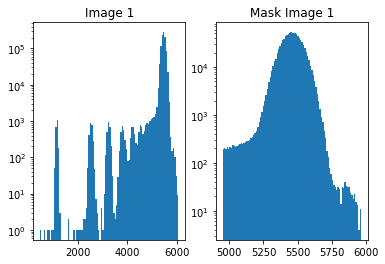

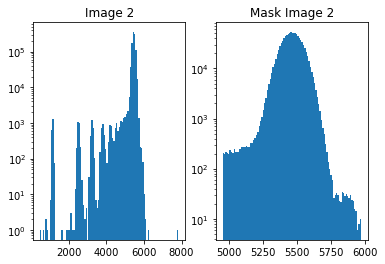

In [135]:
amp = 'C00'
region = amp_object[amp]
im1Area = exp1.maskedImage[region]
im2Area = exp2.maskedImage[region]

fig, axes = plt.subplots(1,2)
axes[0].set_title('Image 1')
axes[0].hist(im1Area.image.array.ravel(), bins=100);
axes[0].set_yscale('log')

axes[1].set_title('Mask Image 1')
im1_mask = np.ma.masked_where(im1Area.mask.array, im1Area.image.array)
clip = sigma_clip(im1_mask, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc)
axes[1].hist(clip.ravel(), bins=100);
axes[1].set_yscale('log')

fig, axes = plt.subplots(1,2)
axes[0].set_title('Image 2')
axes[0].hist(im2Area.image.array.ravel(), bins=100);
axes[0].set_yscale('log')

axes[1].set_title('Mask Image 2')
im2_mask = np.ma.masked_where(im2Area.mask.array, im2Area.image.array)
clip = sigma_clip(im2_mask, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc)
axes[1].hist(clip.ravel(), bins=100);
axes[1].set_yscale('log')



In [181]:
print(maskNameList)
print(im1Area.mask.printMaskPlanes())
print(np.where(im1Area.mask.array == 1))
bit = 9
np.where(np.bitwise_and(im1Area.mask.array, bit))

['SUSPECT', 'BAD', 'NO_DATA', 'SAT']
None
Plane 0 -> BAD
Plane 3 -> CR
Plane 5 -> DETECTED
Plane 6 -> DETECTED_NEGATIVE
Plane 4 -> EDGE
Plane 2 -> INTRP
Plane 8 -> NO_DATA
Plane 1 -> SAT
Plane 7 -> SUSPECT
Plane 9 -> UNMASKEDNAN
(array([1506, 1507, 1507, 1508, 1508]), array([342, 341, 342, 341, 342]))


(array([1506, 1507, 1507, 1508, 1508]), array([342, 341, 342, 341, 342]))

In [137]:
def mask_nomask_func(amp, corr_type, region_obj):
    """
    This function calculates the gain using a pair of flats with and without mask in the image.
    
    Parameters
    ----------
    amp: str with amplifier name, e.g. 'C00'
    corr_type: str, one of ['NONE', 'SIMPLE', 'FULL']
    region_obj: `lsst.geom.Box2I`
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    
    Returns
    -------
    gain_nomask: float, gain calculated without mask
    gain_mask: float, gain calculated with mask
    rel_nomask: float, relative percentage error between gain from 'gain_nomask' and PTC gain
    rel_mask: float, relative percentage error between gain from 'gain_mask' and PTC gain
    """
    
    #mask1, stat_c, mu1= getImageAreasMasksStats(exp1, region=region_obj)
    
    if corr_type == 'NONE':
        gain_nomask = getGainFromFlatPair_noMask(exp1, exp2, correctionType='NONE',
                                readNoise=None, region=region_obj)
        gain_mask = getGainFromFlatPair_noMask2(exp1, exp2, correctionType='NONE', 
                                               readNoise=None, region=region_obj)
    else:
        gain_nomask = getGainFromFlatPair_noMask(exp1, exp2, correctionType=corr_type,
                            readNoise=readNoiseDict[amp][0], region=region_obj)
        gain_mask = getGainFromFlatPair_noMask2(exp1, exp2, correctionType=corr_type, 
                                           readNoise=readNoiseDict[amp][0], region=region_obj)
    rel_nomask = abs(gain_nomask- ptc_gain[amp])/ptc_gain[amp]*100
    rel_mask = abs(gain_mask - ptc_gain[amp])/ptc_gain[amp]*100
        
    return gain_nomask, gain_mask, rel_nomask, rel_mask

/tmp/ipykernel_706/1048777428.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1,2)


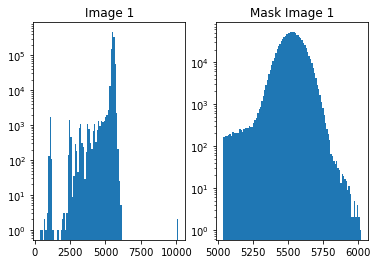

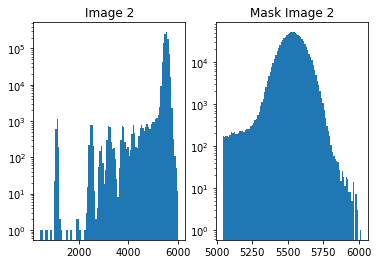

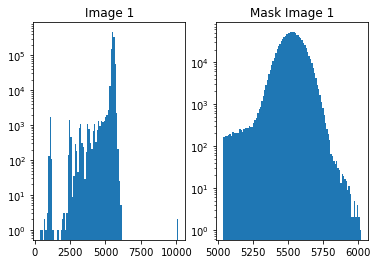

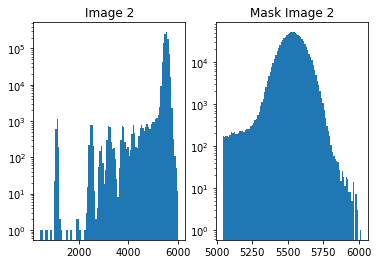

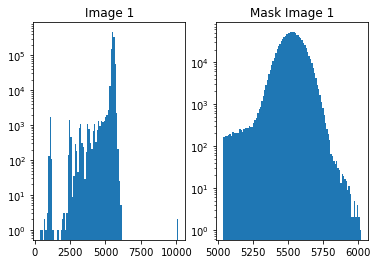

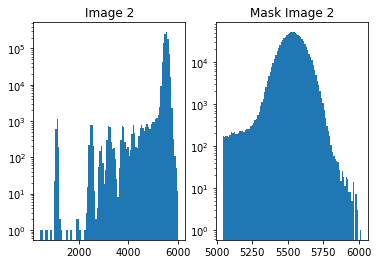

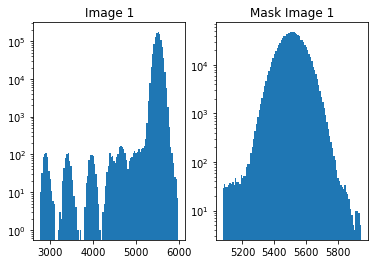

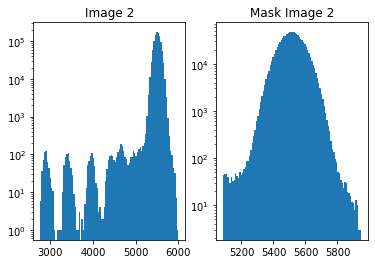

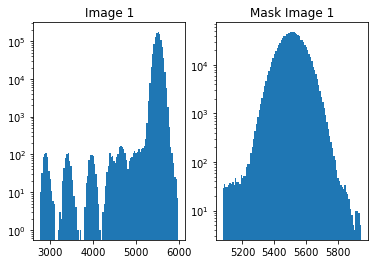

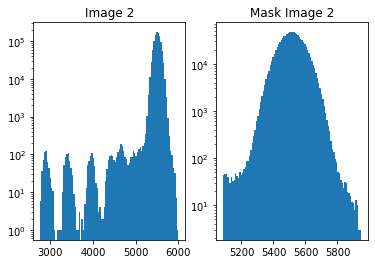

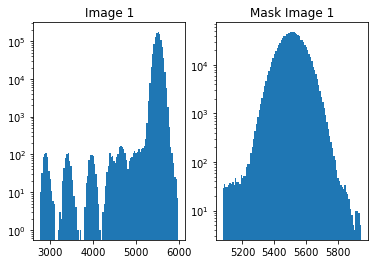

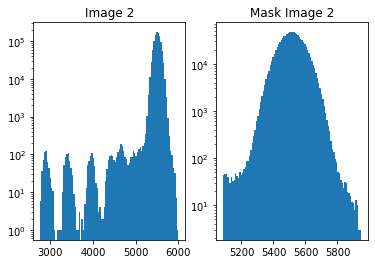

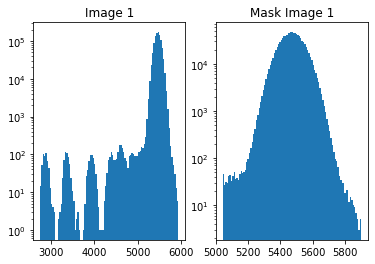

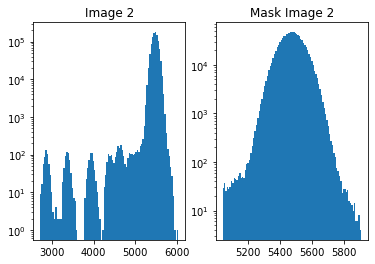

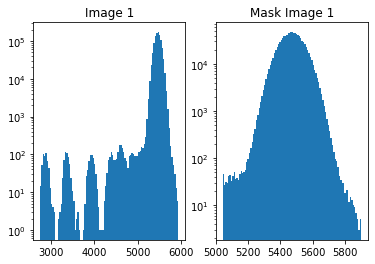

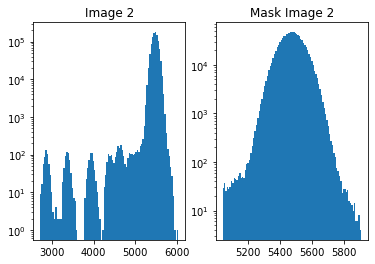

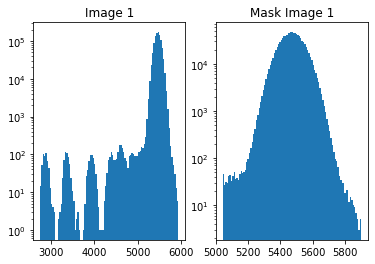

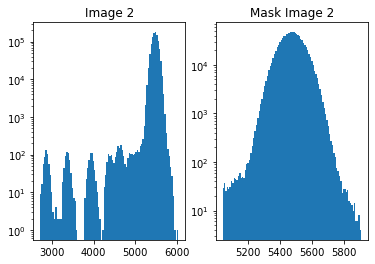

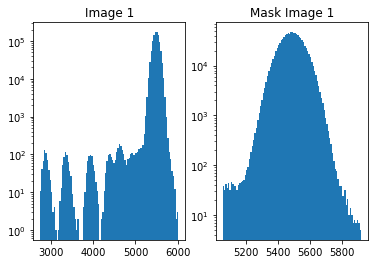

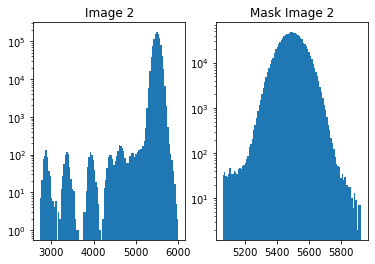

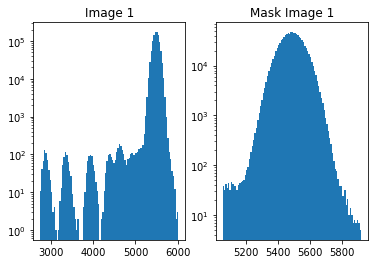

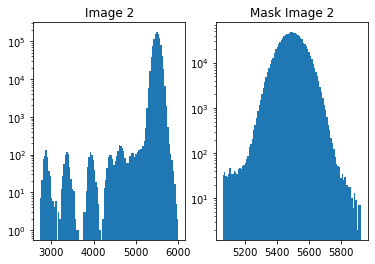

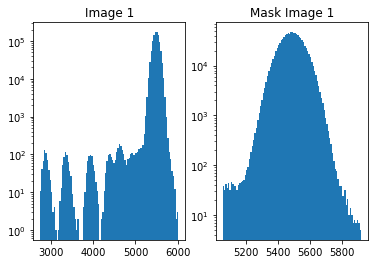

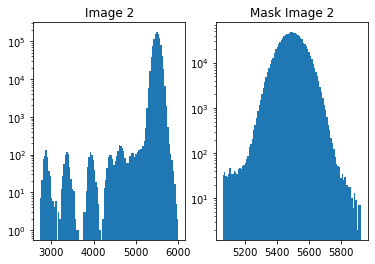

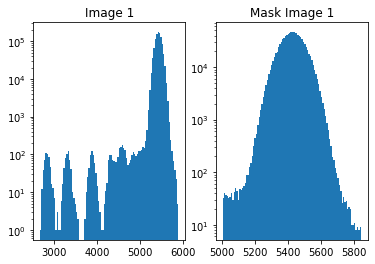

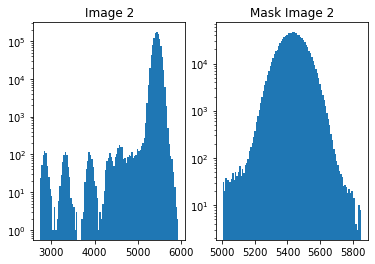

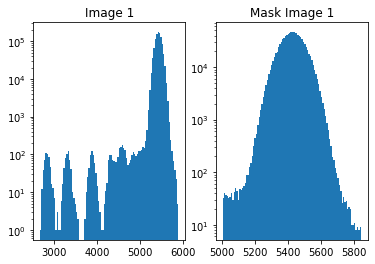

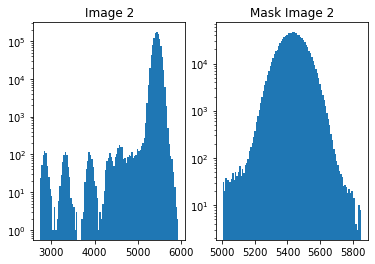

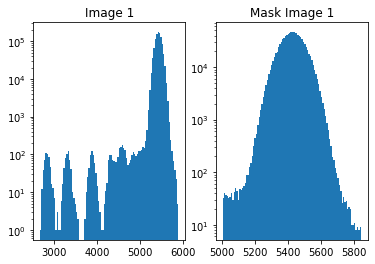

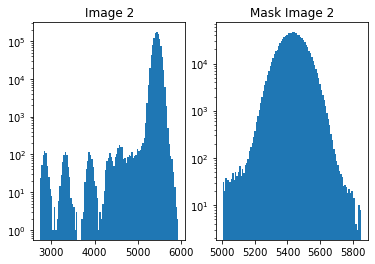

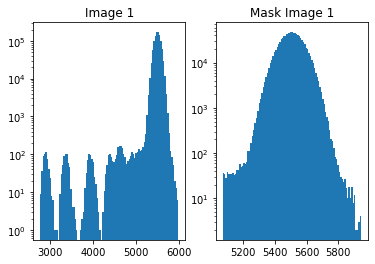

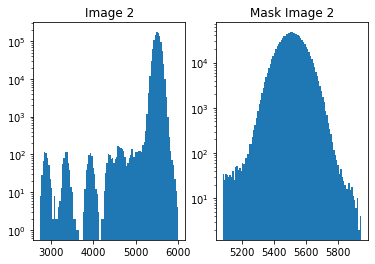

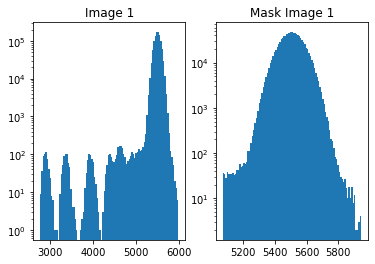

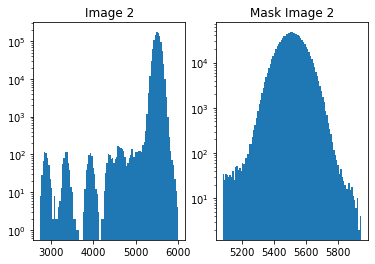

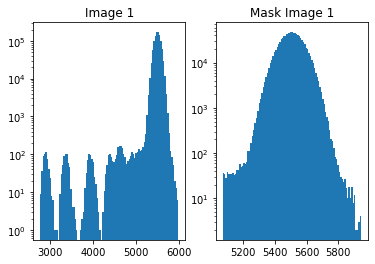

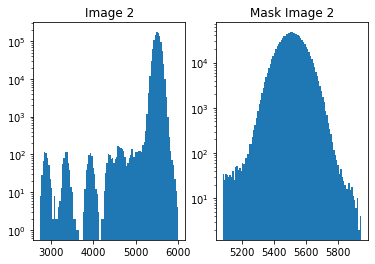

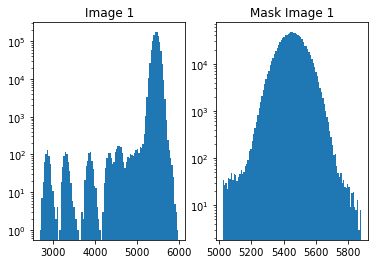

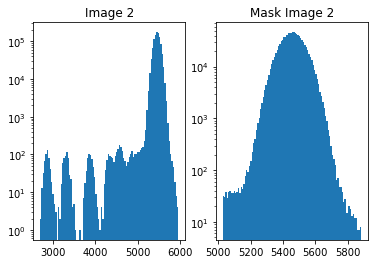

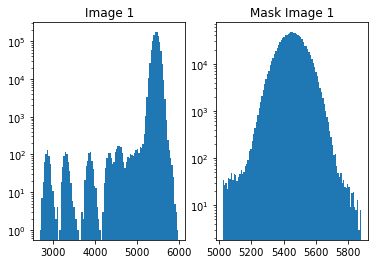

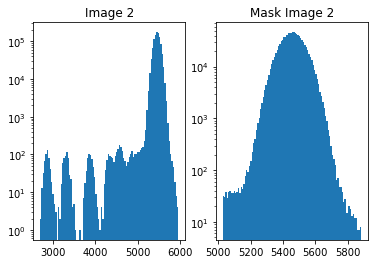

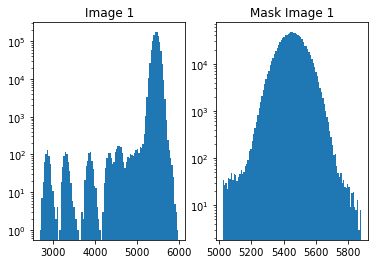

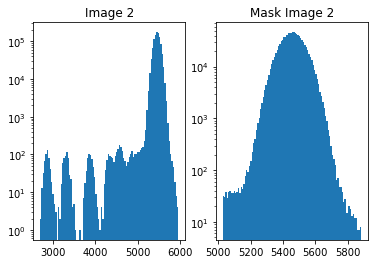

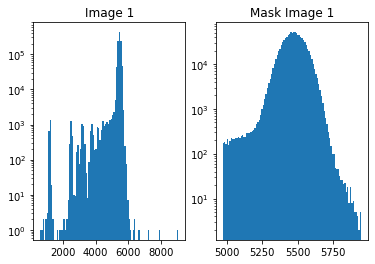

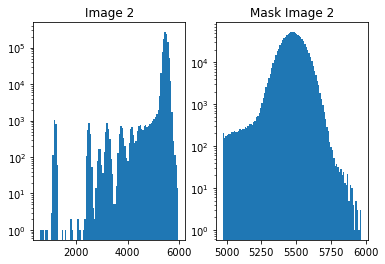

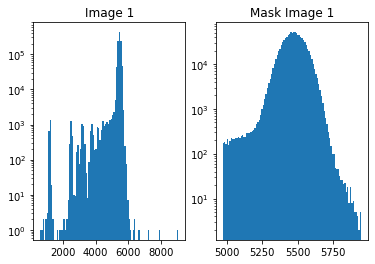

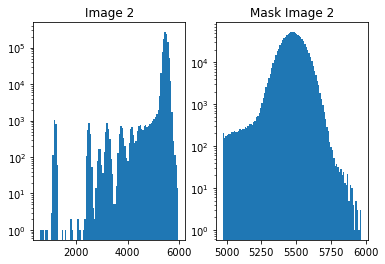

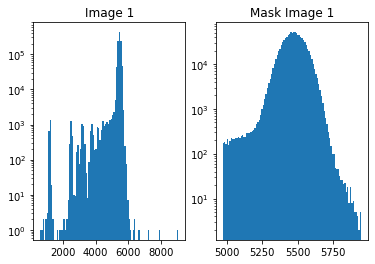

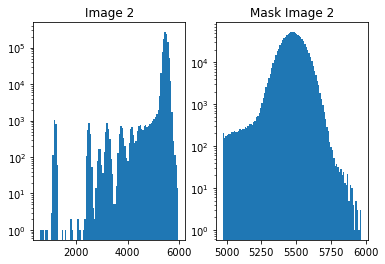

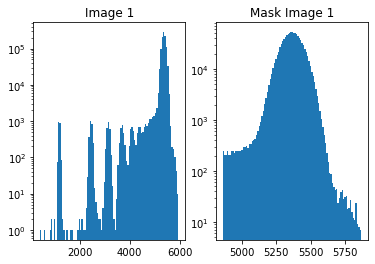

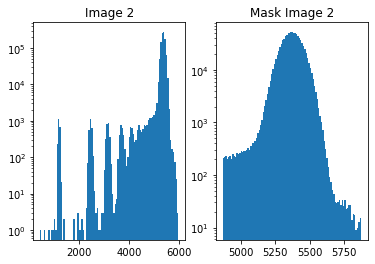

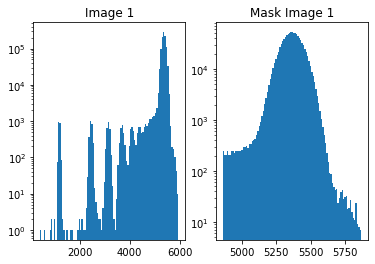

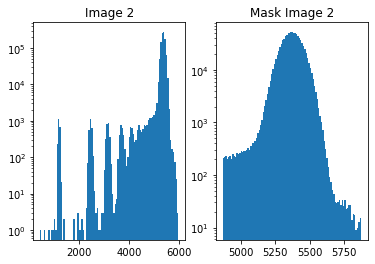

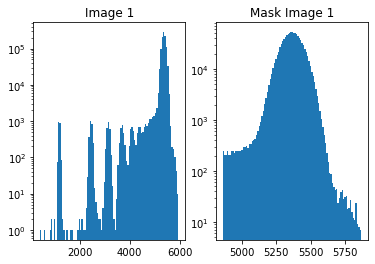

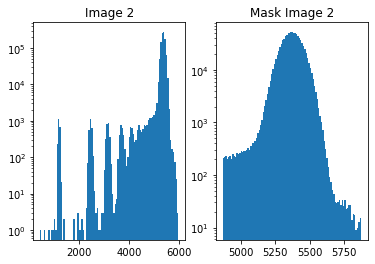

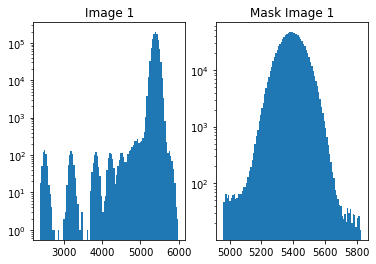

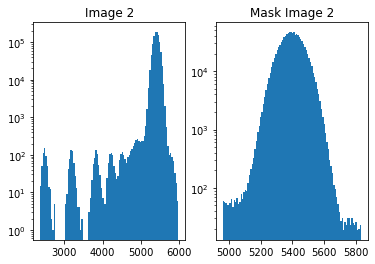

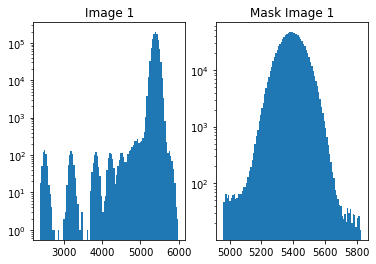

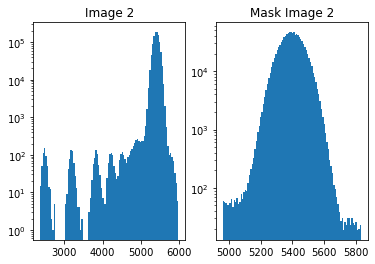

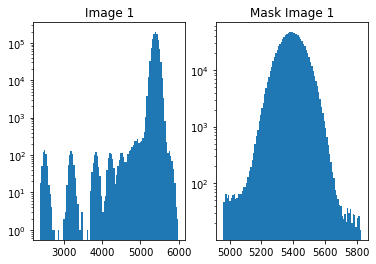

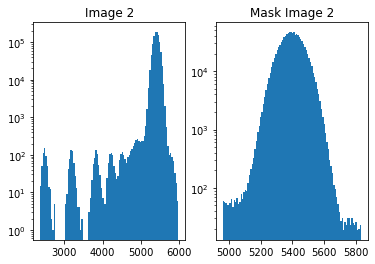

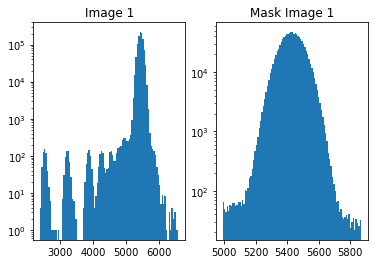

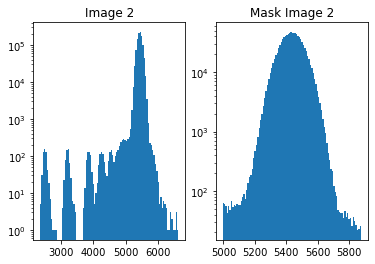

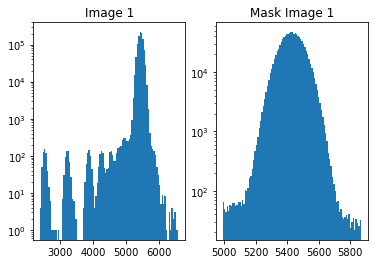

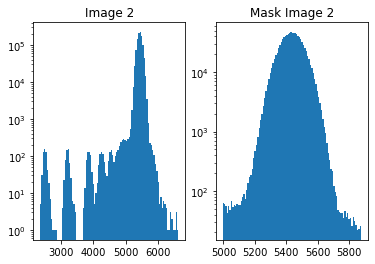

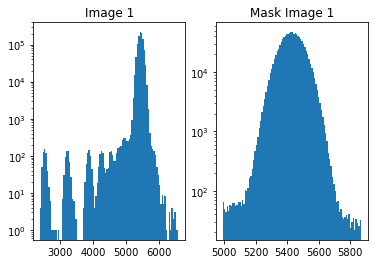

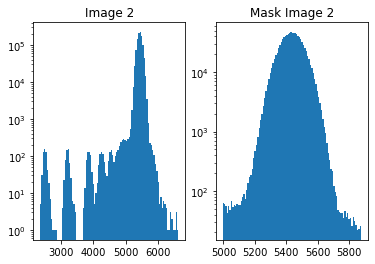

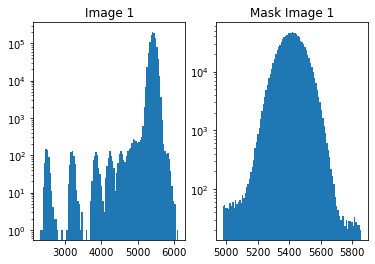

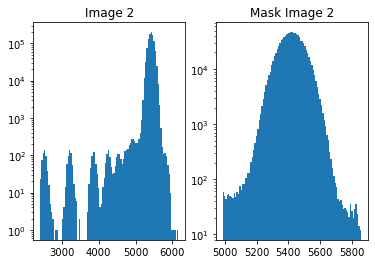

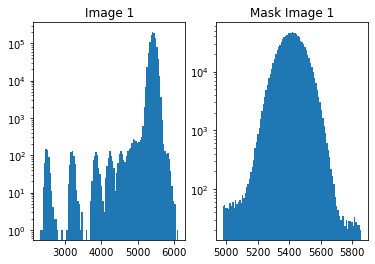

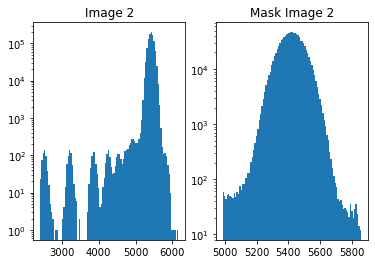

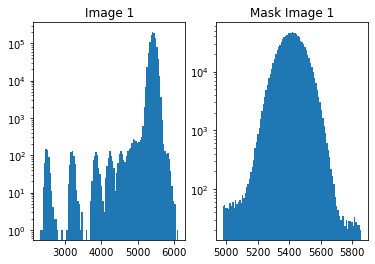

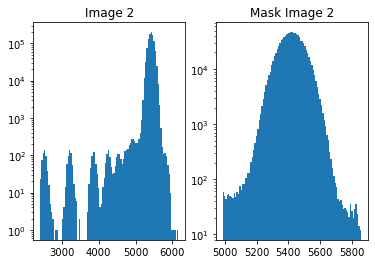

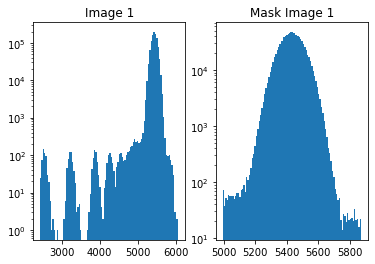

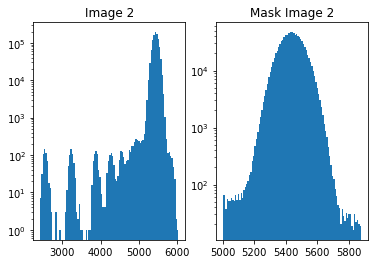

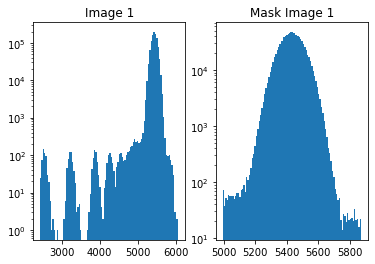

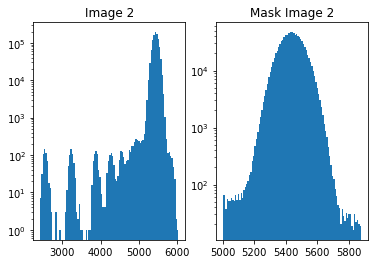

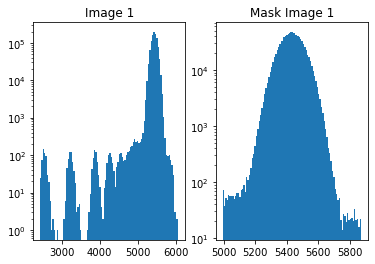

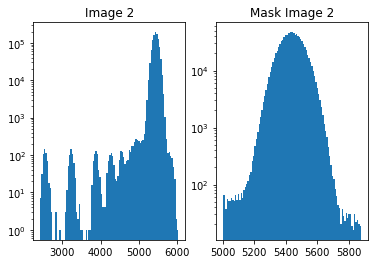

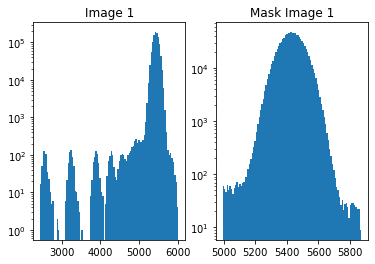

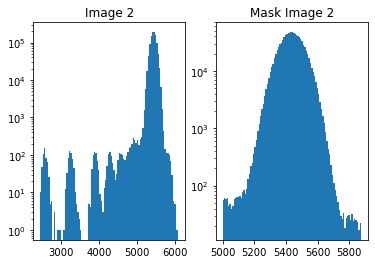

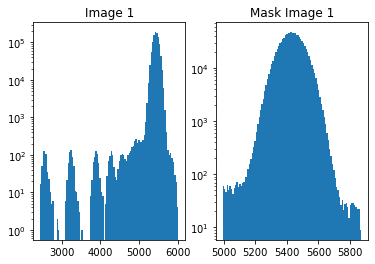

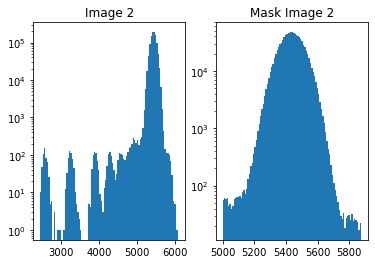

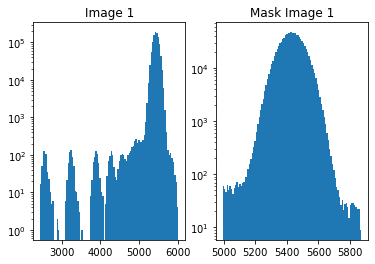

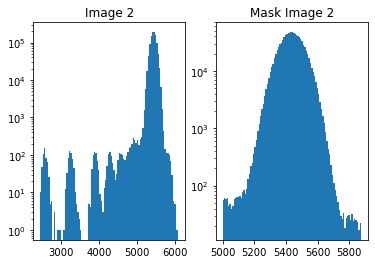

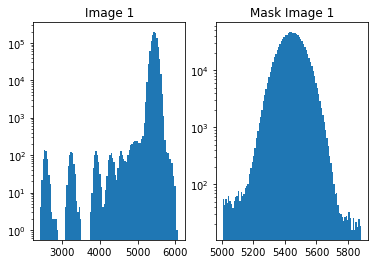

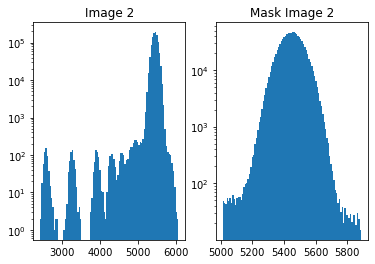

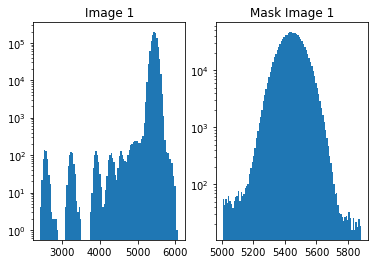

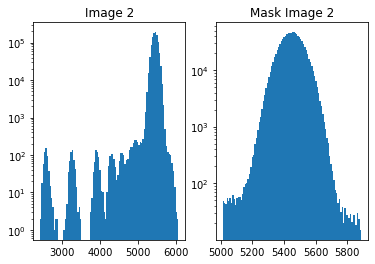

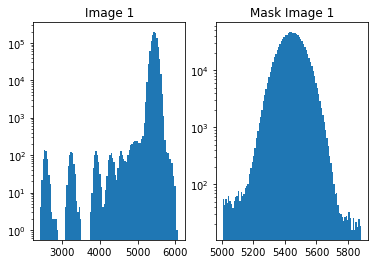

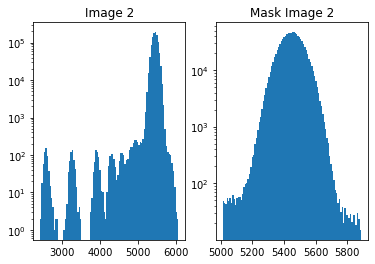

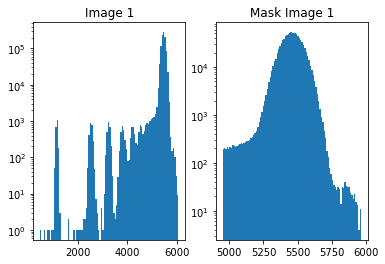

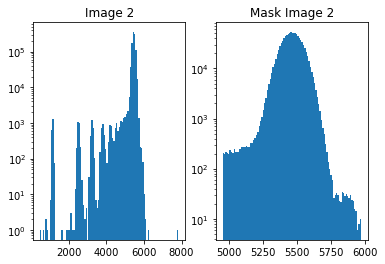

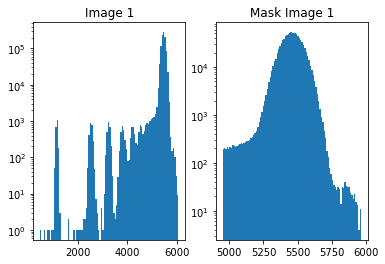

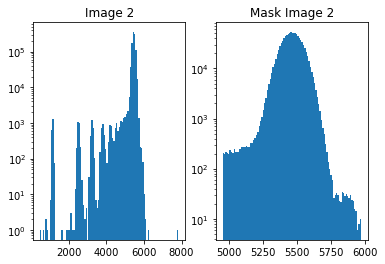

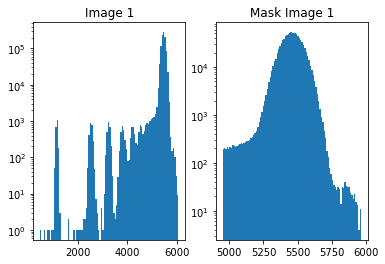

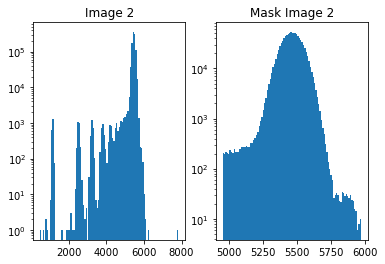

In [138]:
none = [] #gain_nomask, gain_mask, rel_nomask, rel_mask
simple = []
full = []
for amp in ampNames:
    none += [mask_nomask_func(amp, 'NONE', amp_object[amp])]
    simple += [mask_nomask_func(amp, 'SIMPLE', amp_object[amp])]
    full += [mask_nomask_func(amp, 'FULL', amp_object[amp])]
    
none = np.array(none)
simple = np.array(simple)
full = np.array(full)

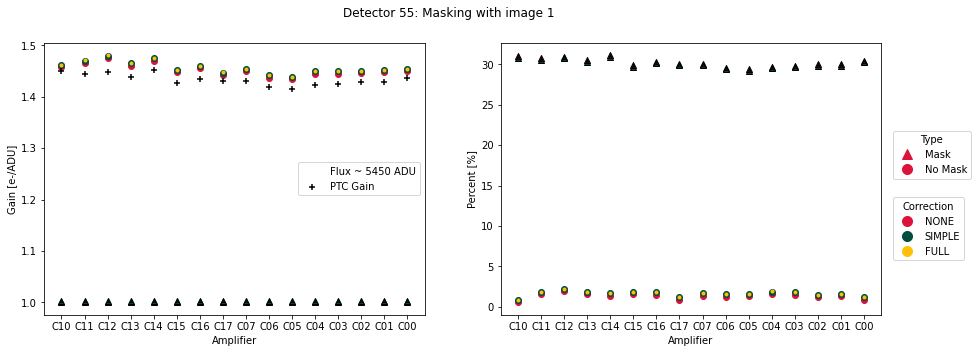

In [140]:
fig,axes = plt.subplots(1,2, figsize= (15,5))
fig.suptitle('Detector 55: Masking with image 1')
axes[0].scatter(ampNames, none[:,0], c= 'crimson')
axes[0].scatter(ampNames, simple[:,0], c= '#004D40')
axes[0].scatter(ampNames, full[:,0], c= '#FFC107', marker = '.')

axes[0].scatter(ampNames, none[:,1], c= 'crimson', marker = '^', edgecolor = 'black')
axes[0].scatter(ampNames, simple[:,1], c= '#004D40',marker = '^', edgecolor = 'black')
axes[0].scatter(ampNames, full[:,1], c= '#FFC107', marker = '^', s = 5, edgecolor = 'black')

axes[0].plot([], [], '.', label='Flux ~ 5450 ADU', ms = 0.5, color='white');
axes[0].scatter(ptc_gain.keys(), ptc_gain.values(), c='black', marker= '+', label='PTC Gain');

axes[1].scatter(ampNames, none[:,2], c= 'crimson')
axes[1].scatter(ampNames, simple[:,2], c= '#004D40')
axes[1].scatter(ampNames, full[:,2], c= '#FFC107', marker = '.')

axes[1].scatter(ampNames, none[:,3], c= 'crimson', marker = '^', edgecolor = 'black')
axes[1].scatter(ampNames, simple[:,3], c= '#004D40', marker = '^', edgecolor = 'black')
axes[1].scatter(ampNames, full[:,3], c= '#FFC107', marker = '^', s = 5, edgecolor = 'black')

for i in range(2):
    axes[i].set_xlabel('Amplifier')
axes[0].set_ylabel('Gain [e-/ADU]')
axes[1].set_ylabel('Percent [%]')

axes[0].legend(loc='best')

t = plt.plot([],[], color="crimson", marker="^", ms=10, ls="")[0]
c = plt.plot([],[], color="crimson", marker="o", ms=10, ls="")[0]
lg1 = plt.legend(handles=[t,c], labels=['Mask','No Mask'],loc=(1.03,0.5), title="Type")
axes[1].add_artist(lg1)
n = plt.plot([],[], color="crimson", marker="o", ms=10, ls="")[0]
s = plt.plot([],[], color='#004D40', marker="o", ms=10, ls="")[0]
f = plt.plot([],[], color='#FFC107', marker="o", ms=10, ls="")[0]
plt.legend(handles=[n,s,f], labels=['NONE','SIMPLE', 'FULL'],loc=(1.03,0.2), title="Correction");

In [97]:
umask = mask1.mask.array
new_arr = np.ma.masked_where(umask, mask1.image.array)
new_arr

masked_array(
  data=[[470.24658203125, 1247.5745849609375, 1639.2816162109375, ...,
         2794.04638671875, 2721.4716796875, 2951.282470703125],
        [641.4144897460938, 1600.1097412109375, 2027.764404296875, ...,
         3414.041259765625, 3498.408935546875, 3564.908203125],
        [805.994140625, 1860.8638916015625, 2487.494140625, ...,
         4012.011962890625, 3994.856689453125, 4102.67822265625],
        ...,
        [1138.9886474609375, 2673.911865234375, 3311.294189453125, ...,
         5707.5234375, 5758.31640625, 5639.05419921875],
        [1264.4027099609375, 2638.190185546875, 3409.173095703125, ...,
         5870.7021484375, 5834.30517578125, 5864.4375],
        [779.0059204101562, 2060.367431640625, 2701.7998046875, ...,
         4837.89111328125, 4878.64404296875, 4929.97802734375]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        .